In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.stats import bayesian_blocks

import cosmology
from hbtp import HBTReader

from src import read

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('paper')

In [3]:
savefig = True

### Analysis parameters

In [4]:
snap = 122
NFW_f = 0.02

In [5]:
zs = pd.read_csv(
    "./data/redshift_list.txt", delimiter=" ", header=None, names=["snap", "z"]
).set_index("snap")

### Halo mass function & binning

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [6]:
def read_haloes(grav, snap):
    hs = HBTReader("./data/%s/subcat" % grav).LoadHostHalos(snap)
    hs["M200Crit"] = 1e10 * hs["M200Crit"]
    hs = hs[hs["M200Crit"] >= 1000 * 1.52315180e8]
    #     hs = hs[hs["CenterOffset"] >= 0.07]
    return hs


def bin_haloes(haloes, bin_column, bin_edges, bin_transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(
        haloes,
        "bin",
        np.digitize(bin_transform(haloes[bin_column]), bin_edges, right=True),
        usemask=False,
    )
    hs = hs[hs["bin"] != 0]
    return hs


def filter_haloes(haloes):
    return (np.log10(haloes["M200Crit"]) > 11.507) & (
        np.log10(haloes["M200Crit"]) < 11.667
    )

In [7]:
haloes_gr = read_haloes("GR_b64n512", 122)
haloes_f6 = read_haloes("fr6_b64n512", 122)
haloes_gr = haloes_gr[filter_haloes(haloes_gr)]
haloes_f6 = haloes_f6[filter_haloes(haloes_f6)]

In [8]:
print(haloes_gr.size)
print(haloes_f6.size)

631
670


### Density profile

In [9]:
def fit_nfw(xs, ps, idx):
    def f(x, c):
        return np.log10(cosmology.nfw.m(np.power(10.0, x), c))

    popt, pcov = curve_fit(
        f, xs[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(xs[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 1 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 1 - 2 * np.log(L)
    print(L, AIC, BIC, chi2)
    return popt


def fit_ein(xs, ps, idx):
    def f(x, c, a):
        return np.log10(cosmology.einasto.m(np.power(10.0, x), c, a))

    popt, pcov = curve_fit(
        f, xs[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0, 1.0]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(xs[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 2 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 2 - 2 * np.log(L)
    print(L, AIC, BIC, chi2)
    return popt

In [10]:
def halo_profiles(hs):
    ps = hs["Profile"]
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    xs = np.linspace(-2.0, 0.0, 20)
    xmax = 0.8
    idx = np.where((np.power(10, xs) < xmax) & (np.power(10, xs) > xmin))
    return ps, xs, np.log10(np.median(np.cumsum(ps, axis=1), axis=0)), idx


def halo_profiles_nfw(ps, xs, idx):
    c = fit_nfw(xs, ps, idx)[0]
    rho_s = np.log10(cosmology.nfw.rho_enc(1.0 / c, c))
    return c, rho_s


def halo_profiles_ein(ps, xs, idx):
    c, a = fit_ein(xs, ps, idx)
    rho_s = np.log10(cosmology.einasto.rho_enc(1.0 / c, c, a))
    return c, a, rho_s

In [11]:
def plot_profiles_nfw(ax, ax_res, haloes, color, res_line):
    ps, xs, p, idx = halo_profiles(haloes)
    c, rho_s = halo_profiles_nfw(ps, xs, idx)
    p_nfw = np.log10(cosmology.nfw.m(np.power(10.0, xs), c))

    #     for _p in ps:
    #         ax.plot(xs, np.log10(np.cumsum(_p, axis=0)), color=color, alpha=0.2)

    ax.fill_between(
        xs,
        np.log10(np.min(np.cumsum(ps, axis=1), axis=0)),
        np.log10(np.max(np.cumsum(ps, axis=1), axis=0)),
        color=color,
        alpha=0.2,
    )

    ax.plot(xs[idx], p_nfw[idx], c=color, ls="-", lw=2)
    ax.axvline(np.log10(1.0 / c), color=color, linestyle="--", linewidth=1)

    ax_res.plot(xs[idx], p_nfw[idx] - res_line[idx], c=color, ls="-", lw=1)
    ax_res.plot(xs[idx], p[idx] - res_line[idx], c=color, ls="--", lw=1)
    ax_res.axvline(np.log10(1.0 / c), c=color, ls="--", lw=1)


def plot_profiles_ein(ax, ax_res, haloes, color, res_line):
    ps, xs, p, idx = halo_profiles(haloes)
    c, a, rho_s = halo_profiles_ein(ps, xs, idx)
    p_ein = np.log10(cosmology.einasto.m(np.power(10.0, xs), c, a))

    #     for _p in ps:
    #         ax.plot(xs, np.log10(np.cumsum(_p, axis=0)), color=color, alpha=0.2)

    ax.fill_between(
        xs,
        np.log10(np.min(np.cumsum(ps, axis=1), axis=0)),
        np.log10(np.max(np.cumsum(ps, axis=1), axis=0)),
        color=color,
        alpha=0.2,
    )

    ax.plot(xs[idx], p_ein[idx], c=color, ls="-", lw=2)
    ax.axvline(np.log10(1.0 / c), color=color, linestyle="--", linewidth=1)

    ax_res.plot(xs[idx], p_ein[idx] - res_line[idx], c=color, ls="-", lw=1)
    ax_res.plot(xs[idx], p[idx] - res_line[idx], c=color, ls="--", lw=1)
    ax_res.axvline(np.log10(1.0 / c), c=color, ls="--", lw=1)

In [12]:
ps_gr, xs_gr, p_gr, idx_gr = halo_profiles(haloes_gr)
c_gr, rho_s_gr = halo_profiles_nfw(ps_gr, xs_gr, idx_gr)
ps_f6, xs_f6, p_f6, idx_f6 = halo_profiles(haloes_f6)
c_f6, rho_s_f6 = halo_profiles_nfw(ps_f6, xs_f6, idx_f6)

0.9989668342573003 2.002067399652644 2.399962672451015 0.0010336998263219953
0.9995312705960075 2.000937678583919 2.3988329513822895 0.0004688392919593286


0.9989668342573003 2.002067399652644 2.399962672451015 0.0010336998263219953
0.9995312705960075 2.000937678583919 2.3988329513822895 0.0004688392919593286


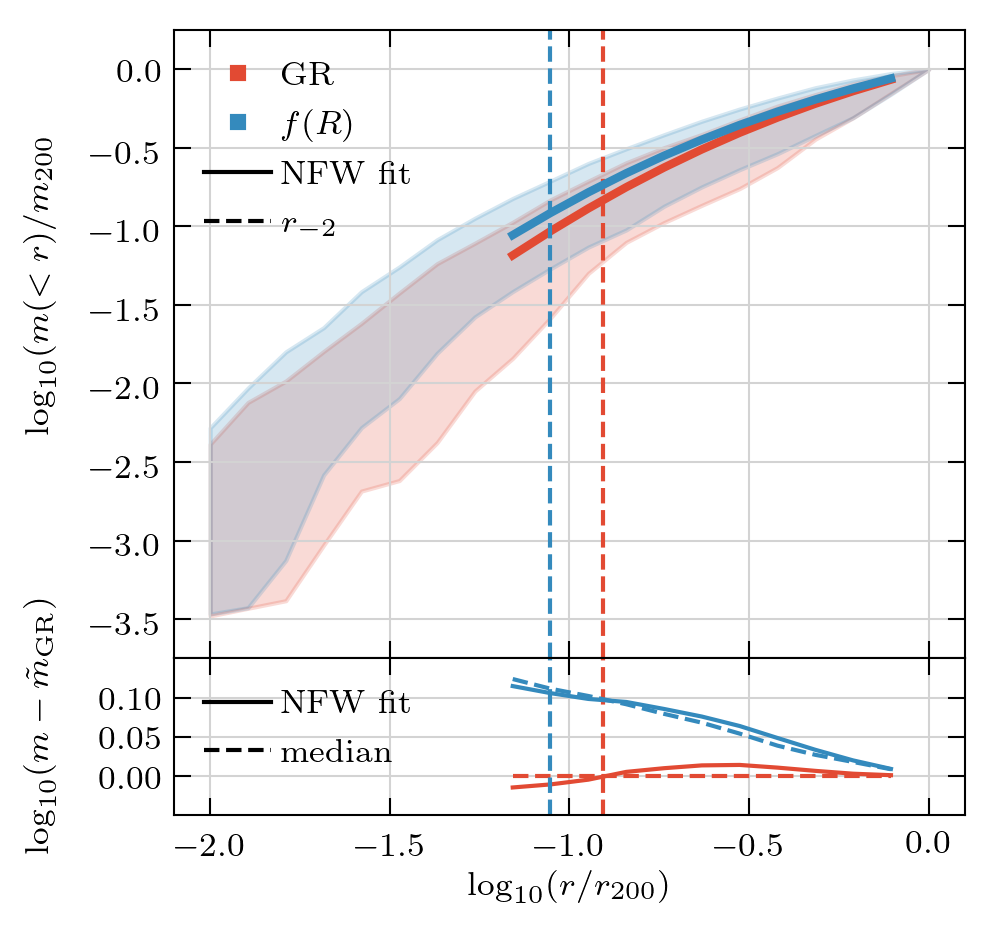

In [13]:
fig = plt.figure(figsize=[3.4, 3.4])
grid = plt.GridSpec(5, 1, hspace=0.0, wspace=0.0)

ax = [
    fig.add_subplot(
        grid[0:-1, 0], xlim=[-2.1, 0.1], ylim=[-3.75, 0.25], xticklabels=[]
    ),
    fig.add_subplot(
        grid[-1, 0], xlim=[-2.1, 0.1], ylim=[-0.05, 0.15], yticks=[0.0, 0.05, 0.1]
    ),
]

ax[1].set_xlabel(r"$\log_{10}(r / r_{200})$")
fig.text(0.0, 0.75, r"$\log_{10}(m(<r) / m_{200}$", ha="center", rotation="vertical")
fig.text(
    0.0, 0.3, r"$\log_{10}(m-\tilde{m}_{\rm GR})$", ha="center", rotation="vertical"
)

plot_profiles_nfw(ax[0], ax[1], haloes_gr, "C0", p_gr)
plot_profiles_nfw(ax[0], ax[1], haloes_f6, "C1", p_gr)

ax[0].legend(
    handles=[
        matplotlib.lines.Line2D(
            [], [], color="C0", marker="s", linestyle="", label="GR"
        ),
        matplotlib.lines.Line2D(
            [], [], color="C1", marker="s", linestyle="", label=r"$f(R)$"
        ),
        matplotlib.lines.Line2D([], [], color="k", linestyle="-", label="NFW fit"),
        matplotlib.lines.Line2D([], [], color="k", linestyle="--", label=r"$r_{-2}$"),
    ]
)
ax[1].legend(
    handles=[
        matplotlib.lines.Line2D([], [], color="k", linestyle="-", label="NFW fit"),
        matplotlib.lines.Line2D([], [], color="k", linestyle="--", label="median"),
    ]
)


if savefig:
    fig.savefig("./plots/prof_nfw_%02d.pdf" % snap)

0.9999295919886373 4.0001408209802465 4.795931366576988 7.04104901230388e-05
0.9998441897325597 4.000311644814242 4.796102190410983 0.00015582240712104354


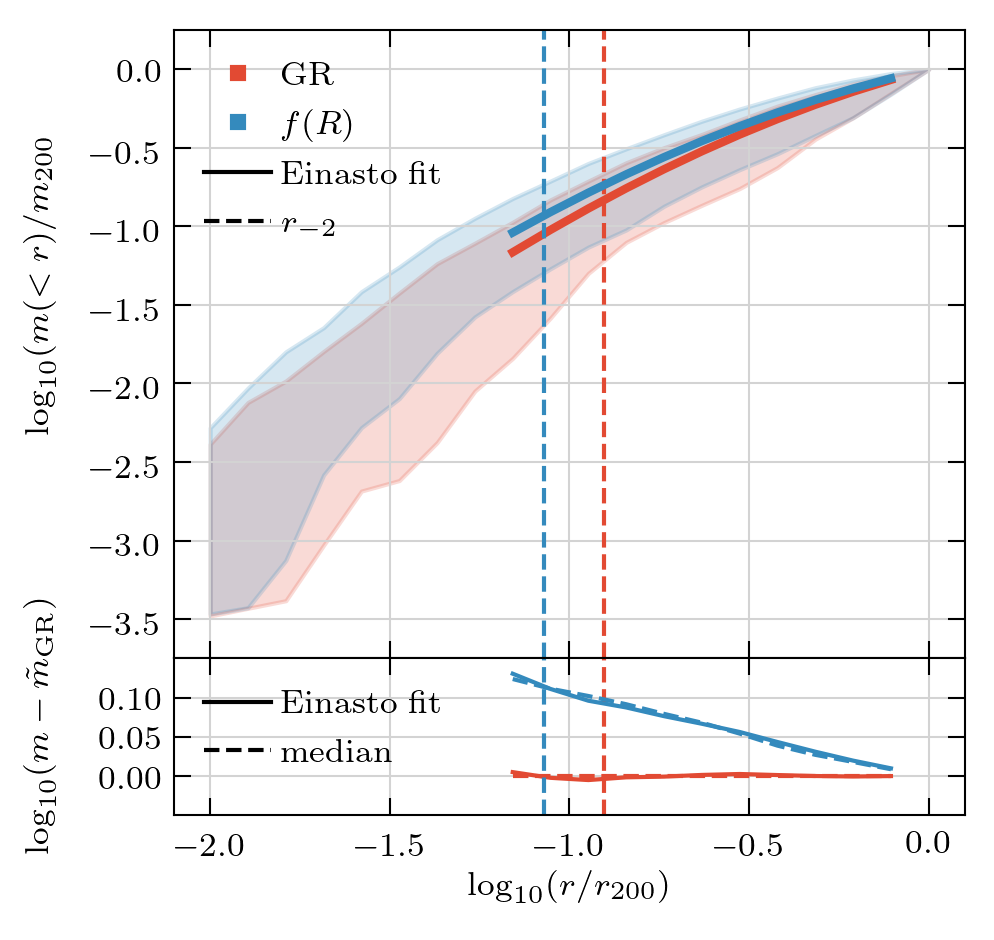

In [14]:
fig = plt.figure(figsize=[3.4, 3.4])
grid = plt.GridSpec(5, 1, hspace=0.0, wspace=0.0)

ax = [
    fig.add_subplot(
        grid[0:-1, 0], xlim=[-2.1, 0.1], ylim=[-3.75, 0.25], xticklabels=[]
    ),
    fig.add_subplot(
        grid[-1, 0], xlim=[-2.1, 0.1], ylim=[-0.05, 0.15], yticks=[0.0, 0.05, 0.1]
    ),
]

ax[1].set_xlabel(r"$\log_{10}(r / r_{200})$")
fig.text(0.0, 0.75, r"$\log_{10}(m(<r) / m_{200}$", ha="center", rotation="vertical")
fig.text(
    0.0, 0.3, r"$\log_{10}(m-\tilde{m}_{\rm GR})$", ha="center", rotation="vertical"
)

plot_profiles_ein(ax[0], ax[1], haloes_gr, "C0", p_gr)
plot_profiles_ein(ax[0], ax[1], haloes_f6, "C1", p_gr)

ax[0].legend(
    handles=[
        matplotlib.lines.Line2D(
            [], [], color="C0", marker="s", linestyle="", label="GR"
        ),
        matplotlib.lines.Line2D(
            [], [], color="C1", marker="s", linestyle="", label=r"$f(R)$"
        ),
        matplotlib.lines.Line2D([], [], color="k", linestyle="-", label="Einasto fit"),
        matplotlib.lines.Line2D([], [], color="k", linestyle="--", label=r"$r_{-2}$"),
    ]
)
ax[1].legend(
    handles=[
        matplotlib.lines.Line2D([], [], color="k", linestyle="-", label="Einasto fit"),
        matplotlib.lines.Line2D([], [], color="k", linestyle="--", label="median"),
    ]
)

if savefig:
    fig.savefig("./plots/prof_ein_%02d.pdf" % snap)

### Collapsed Mass History

In [15]:
def F_nfw(c):
    return cosmology.nfw.m(1.0 / c, c)


def F_ein(c, a):
    return cosmology.einasto.m(1.0 / c, c, a)

In [16]:
def halo_histories(grav, snap, ids, F):
    ms = np.array(
        pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))
        .set_index("HaloId")
        .fillna(0.0)
        .loc[ids]
        .dropna(),
        dtype=float,
    )
    ms = np.divide(ms.T, ms[:, -1]).T
    m = np.median(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array(
            [
                zs[zs["Snapshot"] == s][0]["Redshift"]
                for s in np.arange(1 + snap - ms.shape[1], 1 + snap)
            ]
        )
    ) / cosmology.rho_c(zs[zs["Snapshot"] == snap][0]["Redshift"])

    m_f = F * m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1 / x2) / np.log10(y1 / y2)) * (np.log10(m_f / y1)) + np.log10(
        x1
    )

    return np.log10(ms), np.log10(rho), np.log10(m), rho_f, F

In [17]:
F_nfw(c_gr)

0.14677665244169635

In [18]:
F_nfw(c_f6)

0.12126235893589958

In [19]:
def plot_histories(ax, grav, snap, ids, F, color):
    ms, rho, m, rho_f, F = halo_histories(grav, snap, ids, F)

#     for _m in ms:
#         ax.plot(rho, _m, c=color, alpha=0.2)

    ax.plot(rho, m, c=color, ls="-", lw=2)
    ax.axvline(rho_f, c=color, ls="--", lw=1)
    ax.axhline(np.log10(F), c=color, ls="--", lw=1)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


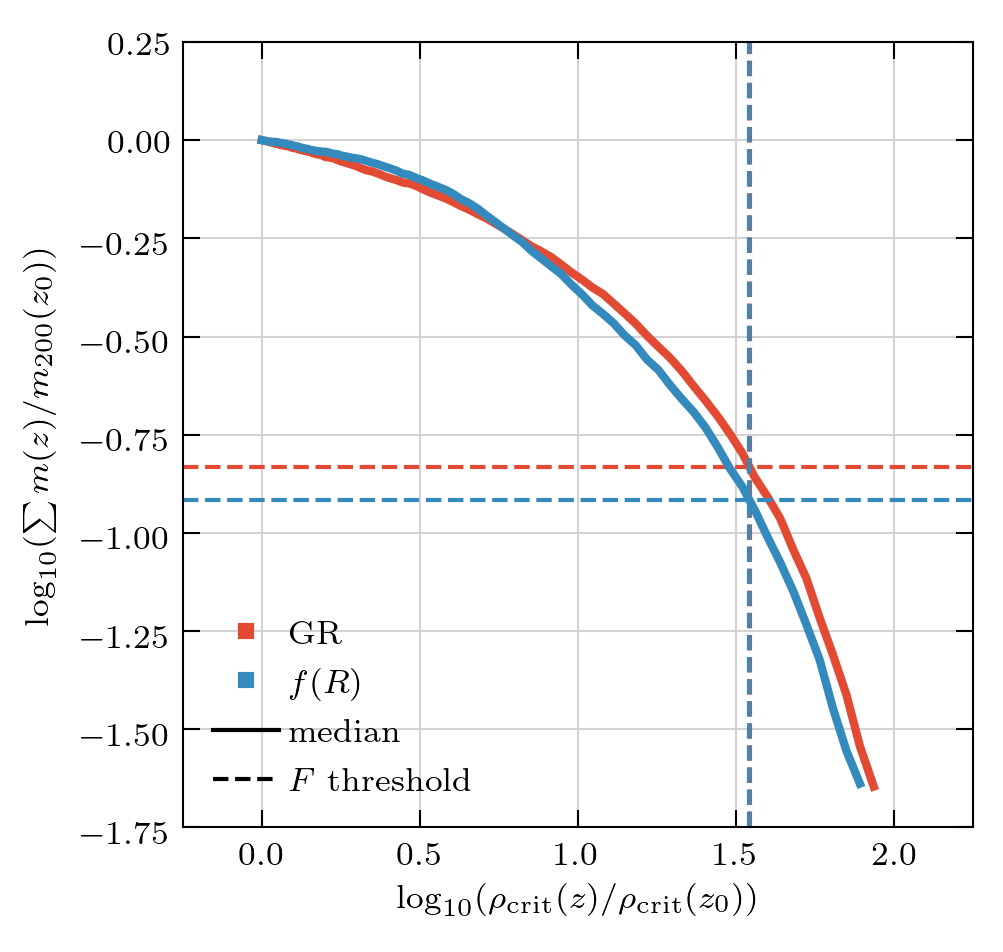

In [20]:
fig, ax = plt.subplots(1, figsize=[3.4, 3.4])

ax.set_xlim([-0.25, 2.25])
ax.set_ylim([-1.75, 0.25])

ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")

plot_histories(ax, "GR_b64n512", 122, haloes_gr["HaloId"], F_nfw(c_gr), "C0")
plot_histories(ax, "fr6_b64n512", 122, haloes_f6["HaloId"], F_nfw(c_f6), "C1")

ax.legend(
    handles=[
        matplotlib.lines.Line2D(
            [], [], color="C0", marker="s", linestyle="", label="GR"
        ),
        matplotlib.lines.Line2D(
            [], [], color="C1", marker="s", linestyle="", label=r"$f(R)$"
        ),
        matplotlib.lines.Line2D([], [], color="k", linestyle="-", label="median"),
        matplotlib.lines.Line2D(
            [], [], color="k", linestyle="--", label=r"$F$ threshold"
        ),
    ]
)

if savefig:
    fig.savefig("./plots/cmh_nfw_f%03d_%02d.pdf" % (100 * NFW_f, snap))

In [21]:
c_gr, a_gr, rho_s_gr = halo_profiles_ein(ps_gr, xs_gr, idx_gr)
c_f6, a_f6, rho_s_f6 = halo_profiles_ein(ps_f6, xs_f6, idx_f6)

0.9999295919886373 4.0001408209802465 4.795931366576988 7.04104901230388e-05
0.9998441897325597 4.000311644814242 4.796102190410983 0.00015582240712104354


In [22]:
F_ein(c_gr, a_gr)

0.14746884402212246

In [23]:
F_ein(c_f6, a_f6)

0.11681702995994185

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


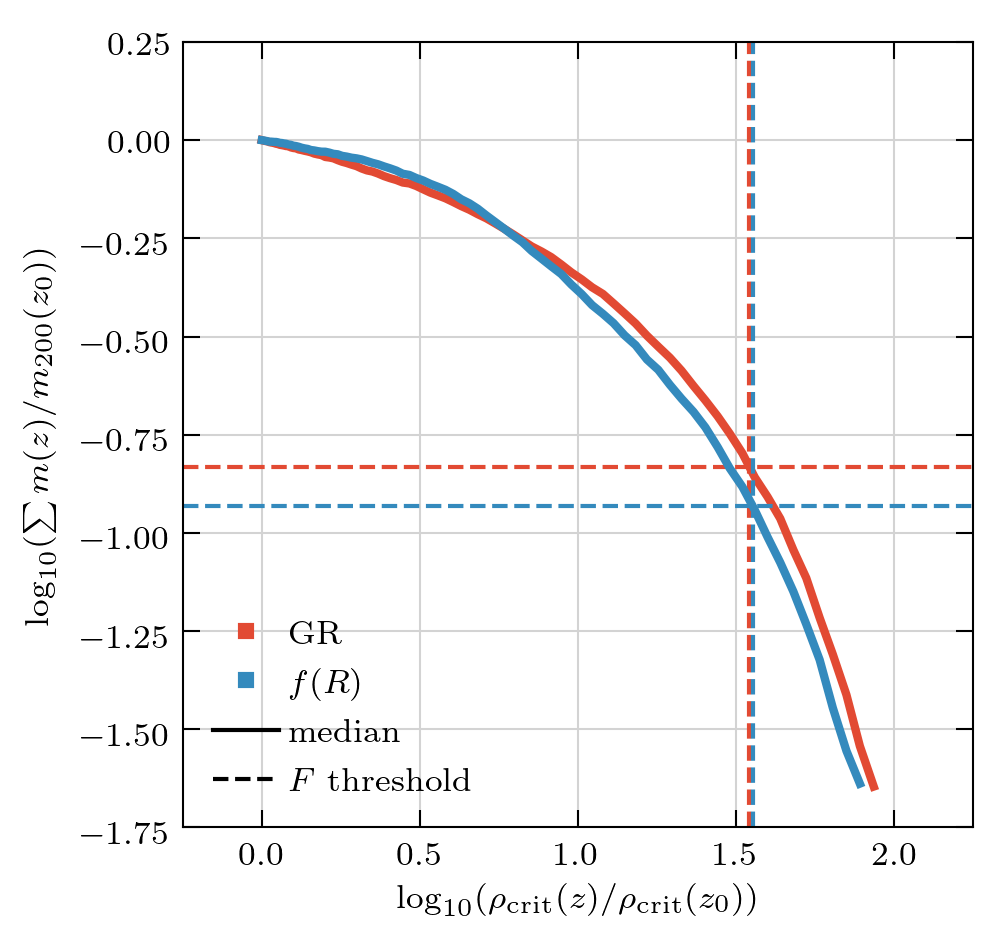

In [24]:
fig, ax = plt.subplots(1, figsize=[3.4, 3.4])

ax.set_xlim([-0.25, 2.25])
ax.set_ylim([-1.75, 0.25])
ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")

plot_histories(ax, "GR_b64n512", 122, haloes_gr["HaloId"], F_ein(c_gr, a_gr), "C0")
plot_histories(ax, "fr6_b64n512", 122, haloes_f6["HaloId"], F_ein(c_f6, a_f6), "C1")

ax.legend(
    handles=[
        matplotlib.lines.Line2D(
            [], [], color="C0", marker="s", linestyle="", label="GR"
        ),
        matplotlib.lines.Line2D(
            [], [], color="C1", marker="s", linestyle="", label=r"$f(R)$"
        ),
        matplotlib.lines.Line2D([], [], color="k", linestyle="-", label="median"),
        matplotlib.lines.Line2D(
            [], [], color="k", linestyle="--", label=r"$F$ threshold"
        ),
    ]
)

if savefig:
    fig.savefig("./plots/cmh_ein_f%03d_%02d.pdf" % (100 * NFW_f, snap))